In [ ]:
import cv2
import matplotlib.pyplot as plt

def show_2images(in_pathfile, out_pathfile):
  # Đường dẫn tới hai bức ảnh
  image_path1 = in_pathfile
  image_path2 = out_pathfile

  # Đọc hai bức ảnh
  image1 = cv2.imread(image_path1)  # Đọc bức ảnh thứ nhất
  image2 = cv2.imread(image_path2)  # Đọc bức ảnh thứ hai

  # Chuyển đổi màu sắc từ BGR sang RGB (để matplotlib hiển thị đúng)
  image1_rgb = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
  image2_rgb = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)

  # Hiển thị hai bức ảnh cạnh nhau
  plt.figure(figsize=(15, 10))  # Kích thước của hình hiển thị (chiều rộng, chiều cao)

  # Hiển thị bức ảnh thứ nhất bên trái
  plt.subplot(1, 2, 1)
  plt.imshow(image1_rgb)
  # plt.title('INPUT IMAGE')
  plt.title('INPUT IMAGE\n{} x {}'.format(image1_rgb.shape[1], image1_rgb.shape[0]))
  plt.axis('off')  # Tắt trục toạ độ

  # Hiển thị bức ảnh thứ hai bên phải
  plt.subplot(1, 2, 2)
  plt.imshow(image2_rgb)
  # plt.title('OUPUT IMAGE')
  plt.title('OUTPUT IMAGE\n{} x {}'.format(image2_rgb.shape[1], image2_rgb.shape[0]))

  plt.axis('off')  # Tắt trục toạ độ

  plt.show()  # Hiển thị hai bức ảnh cạnh nhau

In [ ]:
%%writefile resize_image_GPU.py
import os
from PIL import Image
import numpy as np
import cv2
from numba import jit, njit, cuda
import math
import argparse
import time

# ignore numba warning
from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning, NumbaWarning
import warnings
warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaWarning)

BLOCK_SIZE_2D = int(os.environ.get('BLOCK_SIZE_2D', 32))
BLOCK_SIZE_1D = int(os.environ.get('BLOCK_SIZE_1D', 32))

def get_image(pathfile):
  img = cv2.imread(pathfile)

  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  return img

def show_image(img):
  return Image.fromarray(img)

def save_image(img, pathfile):
  cv2.imwrite(pathfile, cv2.cvtColor(img, cv2.COLOR_RGB2BGR))

def rotate90_right(img):
  img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
  return img

def rotate90_left(img):
  img = cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)
  return img

@cuda.jit
def convert_RGB2Gray_kernel(inImg, outImg, height, width):
  r, c = cuda.grid(2)
  if r < height and c < width:
    outImg[r][c] = inImg[r][c][0]*0.299 + inImg[r][c][1]*0.587 + inImg[r][c][2]*0.114

@cuda.jit
# forward energy
def calc_energy_map_kernel(gray_img, energy_map, height, width, m, idx_row):
    c = cuda.grid(1)
    if c < width:
        # Calculate row indices for the pixel above and its neighbors
        up = (idx_row-1) % height
        left = (c-1) % width
        right = (c+1) % width

        # Retrieve energy accumulated from the pixel above and its neighbors
        mU = m[up, c]
        mL = m[up, left]
        mR = m[up, right]

        # Calculate energy changes for the current pixel
        cU = abs(gray_img[idx_row, right] - gray_img[idx_row, left])
        cL = abs(gray_img[up, c] - gray_img[idx_row, left]) + cU
        cR = abs(gray_img[up, c] - gray_img[idx_row, right]) + cU

        # Update energy
        mU += cU
        mL += cL
        mR += cR

        _mMin = mU
        _cMin = cU

        if mL < _mMin:
            _mMin = mL
            _cMin = cL

        if mR < _mMin:
            _mMin = mR
            _cMin = cR

        # Store the minimum energy
        m[idx_row, c] = _mMin
        energy_map[idx_row, c] = _cMin

@cuda.jit
def get_least_importance_map_kernel(energy_map, least_importance_map, height, width, idx_row):
  c = cuda.grid(1)
  if c < width:
     # Calculate the least importance map for the current row (idx_row)
    if c == 0: # check first column
      least_importance_map[idx_row][c] = min(least_importance_map[idx_row+1,0], least_importance_map[idx_row+1,1]) + energy_map[idx_row][c]
    elif c == width - 1: # check last column
      least_importance_map[idx_row][c] = min(least_importance_map[idx_row+1,width-2], least_importance_map[idx_row+1,width-1]) + energy_map[idx_row][c]
    else:
      least_importance_map[idx_row][c] = min(least_importance_map[idx_row+1,c-1],least_importance_map[idx_row+1,c],least_importance_map[idx_row+1,c+1]) + energy_map[idx_row][c]

@njit
def find_seam(inPixels):
  # Find the index of the minimum energy pixel in the first row
  min_index = np.argmin(inPixels[0])

  height, width = inPixels.shape[:2]
  idxSeam = []
  idxSeam.append(min_index)

  for r in range(1, height):
    # If the minimum energy pixel is in the first column
    if min_index == 0:
      min_index = np.argmin(inPixels[r][min_index:min_index+2])
      idxSeam.append(min_index)
      continue
    # If the minimum energy pixel is in the last column
    if min_index == width - 1:
      min_index = np.argmin(inPixels[r][min_index-1:min_index+1]) + min_index - 1
      idxSeam.append(min_index)
      continue
    # For pixels in the middle columns
    min_index = np.argmin(inPixels[r][min_index-1:min_index+2]) + min_index - 1
    idxSeam.append(min_index)

  return idxSeam

@cuda.jit
def remove_seam_kernel(inImg, pathSeam, height, width, outImg):
  r, c = cuda.grid(2)
  if r < height and c < width:
    if pathSeam[r] <= c:
      for channel in range(3):
        outImg[r][c][channel] = inImg[r][c + 1][channel]
    else:
      for channel in range(3):
        outImg[r][c][channel] = inImg[r][c][channel]

def remove_nSeams(img, nSeams):
  # Initialize block sizes for CUDA threads
  block_size_1D = BLOCK_SIZE_1D
  block_size_2D = BLOCK_SIZE_2D, BLOCK_SIZE_2D

  for _ in range(nSeams):
    height, width = img.shape[:2]

    # Calculate grid sizes for CUDA threads
    grid_size_1D = (math.ceil(width / block_size_1D))
    grid_size_2D = (math.ceil(height / block_size_2D[0]),
                    math.ceil(width / block_size_2D[1]))
    # Move input image to the GPU (device)
    d_img = cuda.to_device(img)

    # Allocate device memory
    d_gray_img = cuda.device_array((height, width), dtype=np.float64)
    d_energy_map = cuda.device_array((height, width), dtype=np.float64)
    d_least_importance_map = cuda.device_array((height,width), dtype=np.float64)

    # Convert the RGB image to grayscale using CUDA kernel
    convert_RGB2Gray_kernel[grid_size_2D, block_size_2D](d_img, d_gray_img, height, width)

    # Calculate energy map kernel
    d_m = cuda.device_array((height, width), dtype=np.float64)

    for r in range(1, height):
      calc_energy_map_kernel[grid_size_1D, block_size_1D](d_gray_img, d_energy_map, height, width, d_m, r)

    # Calculate least importance map
    d_least_importance_map[height-1][:width] = d_energy_map[height-1][:width]

    for r in range(height-2, -1, -1):
      get_least_importance_map_kernel[grid_size_1D, block_size_1D](d_energy_map, d_least_importance_map, height, width, r)

    leastImportancePixels = d_least_importance_map.copy_to_host()

    # find seam
    pathSeam = find_seam(leastImportancePixels)


    # remove seam
    d_pathSeam = cuda.to_device(pathSeam)
    d_out = cuda.device_array((height, width-1, 3), dtype=np.uint8)

    remove_seam_kernel[grid_size_2D, block_size_2D](d_img, d_pathSeam, height, width-1, d_out)

    # Copy the output image back to the host
    img = d_out.copy_to_host()

  return img

@cuda.jit
def insert_seam_kernel(inImg, pathSeam, height, width, outImg):
  r, c = cuda.grid(2)
  if r < height and c < width:
      if pathSeam[r] == c: # check the position to insert
          if c == 0:
              for channel in range(3):
                  outImg[r][c][channel] = (img[r, c, channel] + img[r, c + 1, channel]) / 2
                  outImg[r][c + 1][channel] = img[r][c][channel]
          else:
              for ch in range(3):
                  outImg[r][c][channel] = (img[r, c - 1, channel] + img[r, c, channel]) / 2
                  outImg[r][c + 1][channel] = img[r][c][channel]

      elif c < pathSeam[r]: # before position to insert seam
          for ch in range(3):
              outImg[r][c][channel] = img[r][c][channel]

      else: # after position to insert seam
          for ch in range(3):
              outImg[r][c + 1][channel] = img[r][c][channel]

@njit
def insert_seam(img, idxSeam):
  height, width = img.shape[:2]
  outImg = np.zeros((height, width+1, 3),dtype=np.uint8)

  for r in range(height):
    c = idxSeam[r]
    if c == 0: # check first column
      outImg[r][0] = img[r][0]
      #outImg[r][0] =[0,0,0]
      outImg[r][1] = img[r][0]
      outImg[r][2:] = img[r][1:]
      continue

    if c == width-1: # check last column
      outImg[r][:width] = img[r][:]
      outImg[r][-1] = img[r][-1]
      #outImg[r][-1] = [0,0,0]
      continue

    # middle column
    outImg[r][:c+1] = img[r][:c+1]
    outImg[r][c+1] = (img[r][c] + img[r][c+1]) / 2
    #outImg[r][c+1] = [0,0,0]
    outImg[r][c+2:] = img[r][c+1:]

  return outImg

def insert_nSeams(img, nSeams):
  # Initialize block sizes for CUDA threads
  block_size_1D = BLOCK_SIZE_1D
  block_size_2D = BLOCK_SIZE_2D, BLOCK_SIZE_2D

  tmp_img = img.copy()

  # List to record the seams that are inserted
  seams_record  = []

  for _ in range(nSeams):
    height, width = tmp_img.shape[:2]

    # Calculate grid sizes for CUDA threads
    grid_size_1D = (math.ceil(width / block_size_1D))
    grid_size_2D = (math.ceil(height / block_size_2D[0]),
                    math.ceil(width / block_size_2D[1]))

    # Move the image to the GPU (device)
    d_img = cuda.to_device(tmp_img)

    # Allocate device memory
    d_gray_img = cuda.device_array((height, width), dtype=np.float64)
    d_energy_map = cuda.device_array((height, width), dtype=np.float64)
    d_least_importance_map = cuda.device_array((height,width), dtype=np.float64)

     # Convert the RGB image to grayscale using CUDA kernel
    convert_RGB2Gray_kernel[grid_size_2D, block_size_2D](d_img, d_gray_img, height, width)


    # Calculate the energy map using CUDA kernel
    d_m = cuda.device_array((height, width), dtype=np.float64)
    for r in range(1, height):
      calc_energy_map_kernel[grid_size_1D, block_size_1D](d_gray_img, d_energy_map, height, width, d_m, r)

    # Calculate least importance map
    # Copy the last row of the energy map to the least importance map
    d_least_importance_map[height-1][:width] = d_energy_map[height-1][:width]

    for r in range(height-2, -1, -1):
      get_least_importance_map_kernel[grid_size_1D, block_size_1D](d_energy_map, d_least_importance_map, height, width, r)

    leastImportancePixels = d_least_importance_map.copy_to_host()

    # find seam
    pathSeam = find_seam(leastImportancePixels)

    # record seam
    seams_record.append(pathSeam)

    # remove seam kernel
    d_pathSeam = cuda.to_device(pathSeam)
    d_out = cuda.device_array((height, width-1, 3), dtype=np.float64)

    remove_seam_kernel[grid_size_2D, block_size_2D](d_img, d_pathSeam, height, width-1, d_out)

    # Copy the output image back to the host
    tmp_img = d_out.copy_to_host()

  seams_record.reverse()

  for _ in range(nSeams):
    # get the seam
    seam = seams_record.pop()

    img = insert_seam(img, seam)

    # Update the remaining seams_record with new indices after seam insertion
    for i_seam in seams_record:
      mark = np.array(i_seam) >= np.array(seam)
      for i in range(height):
        if mark[i]: i_seam[i] += 2

  return img

if __name__ == '__main__':
  print("Resize image using GPU \n")
  # Tạo đối tượng ArgumentParser
  parser = argparse.ArgumentParser()

  # Thêm các đối số và tùy chọn
  parser.add_argument("-input", type=str, help='path file input')
  parser.add_argument('-output', type=str, help='path file output')

  parser.add_argument('-dx', type=int, help='number of seams - axis x', default = 0)
  parser.add_argument('-dy', type=int, help='number of seams - axis y', default = 0)

  # parser.add_argument('--option', type=float, help='Tùy chọn')

  # Phân tích các tham số dòng lệnh
  args = parser.parse_args()

  img = get_image(args.input)
  print("INPUT:", img.shape)

  start = time.perf_counter()
  if args.dx > 0:
    img = insert_nSeams(img, args.dx)

  if args.dx < 0:
    img = remove_nSeams(img, abs(args.dx))

  if args.dy > 0:
    img = rotate90_left(img)
    img = insert_nSeams(img, args.dy)
    img = rotate90_right(img)

  if args.dy < 0:
    img = rotate90_left(img)
    img = remove_nSeams(img, abs(args.dy))
    img = rotate90_right(img)

  end = time.perf_counter()
  print("OUTPUT:", img.shape)
  print("RUNTIME:",round(end - start,3), "seconds")

  save_image(img, args.output)

Overwriting resize_image_GPU.py


### Thêm 200 pixels vào chiều cao và chiều rộng của bức ảnh

In [ ]:
!python resize_image_GPU.py -input "/content/a.jpg" -output "/content/b.jpg" -dx 200 -dy 200

Resize image using GPU 

INPUT: (434, 640, 3)
OUTPUT: (634, 840, 3)
RUNTIME: 47.555 seconds


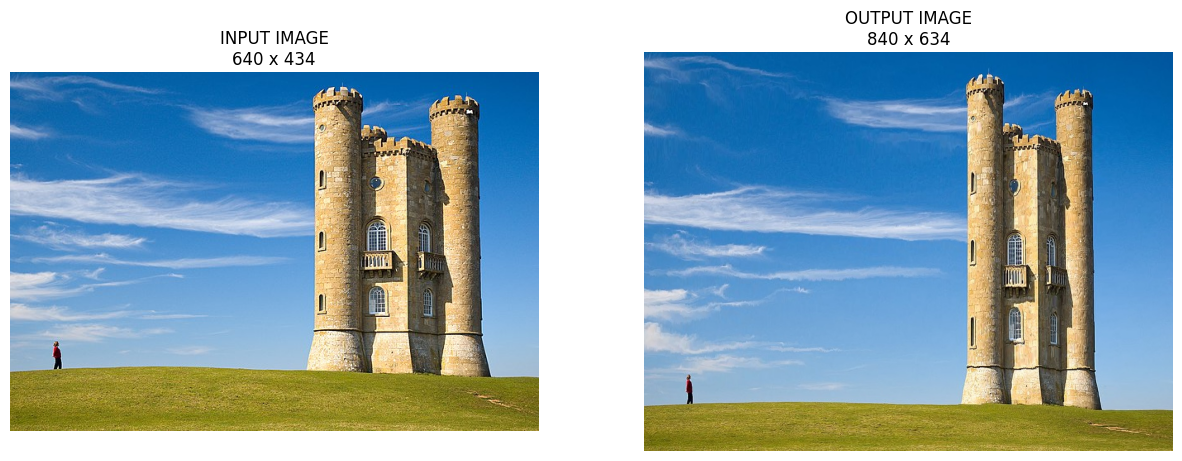

In [ ]:
show_2images("/content/a.jpg","/content/b.jpg")

### Giảm 200 pixels vào chiều cao và chiều rộng của bức ảnh

In [ ]:
!python resize_image_GPU.py -input "/content/a.jpg" -output "/content/b.jpg" -dy -200 -dx -200

Resize image using GPU 

INPUT: (434, 640, 3)
OUTPUT: (234, 440, 3)
RUNTIME: 26.128 seconds


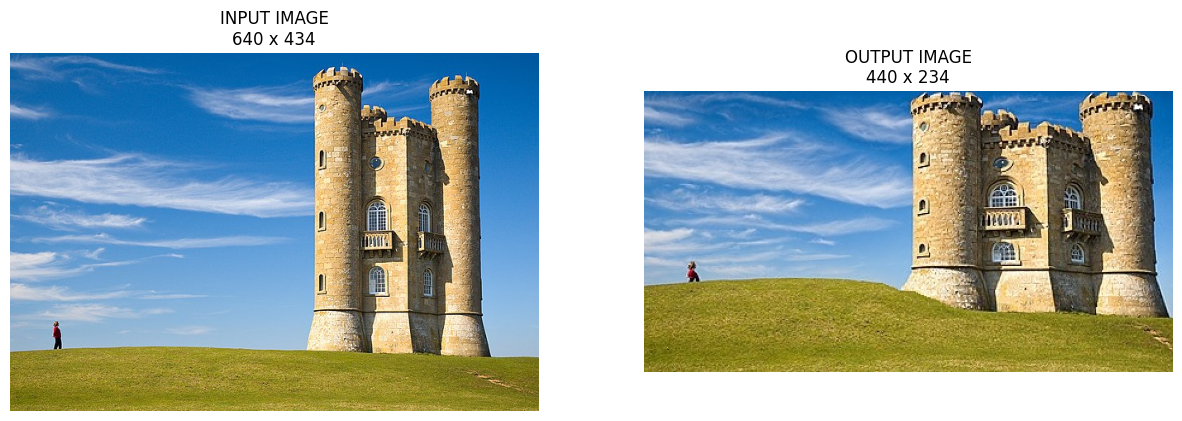

In [ ]:
show_2images("/content/a.jpg","/content/b.jpg")

### Tăng kích thước ảnh thêm 200 pixels chiều ngang và giảm 200 pixels chiều cao

In [ ]:
!python resize_image_GPU.py -input "/content/a.jpg" -output "/content/b.jpg" -dx 200 -dy -200

Resize image using GPU 

INPUT: (434, 640, 3)
OUTPUT: (234, 840, 3)
RUNTIME: 39.482 seconds


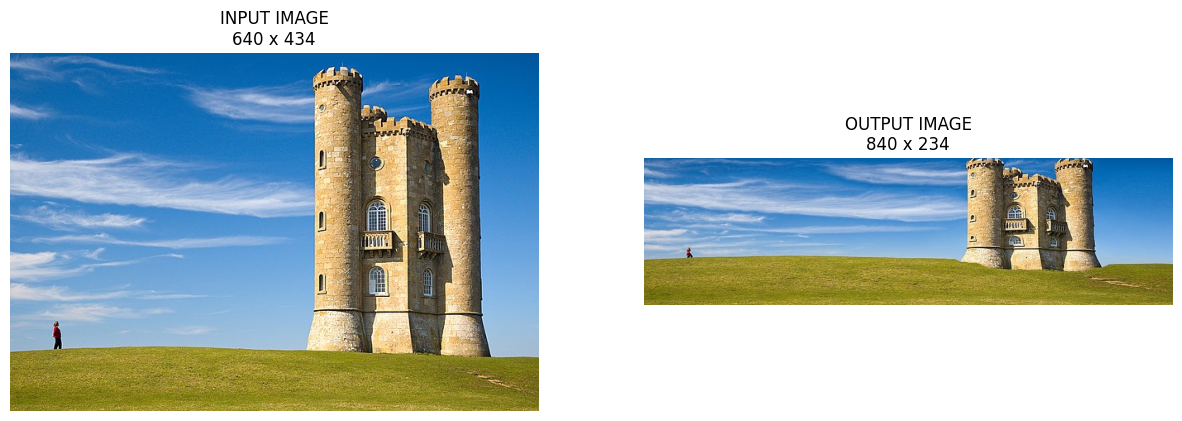

In [ ]:
show_2images("/content/a.jpg","/content/b.jpg")